<a href="https://colab.research.google.com/github/rgrion/mlarrozprevisao/blob/main/Treinamento_Rice_South_America_2011_a_2020_3anos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Lista de anos e dicionário para armazenar
anos = list(range(2011, 2024))
dados_por_ano = {}

for ano in anos:
    df = pd.read_csv(f'/content/Rice_South_America_{ano}.csv')
    df = df[['Area', 'Year', 'Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']].dropna()
    df = df[df['Area'] != 'South America']  # Remover o total agregado
    dados_por_ano[ano] = df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

resultados = []

# Dataset de treino
df_treino = pd.concat([
    dados_por_ano[2011], dados_por_ano[2012], dados_por_ano[2013], dados_por_ano[2014], dados_por_ano[2015],
    dados_por_ano[2016], dados_por_ano[2017], dados_por_ano[2018], dados_por_ano[2019], dados_por_ano[2020],
])
paises = df_treino['Area'].unique()

# Loop de previsão
for ano in range(2021, 2024):
    df_real = dados_por_ano[ano]

    for pais in paises:
        try:
            df_pais_treino = df_treino[df_treino['Area'] == pais]
            df_pais_real = df_real[df_real['Area'] == pais]

            if len(df_pais_treino) < 2 or df_pais_real.empty:
                continue

            # Dados de treino e predição
            X_train = df_pais_treino[['Year', 'Area harvested (ha)']]
            y_train = df_pais_treino['Production (t)']

            area_pred = df_pais_real['Area harvested (ha)'].values[0]
            X_pred = pd.DataFrame({'Year': [ano], 'Area harvested (ha)': [area_pred]})

            # Treinamento dos modelos
            lr = LinearRegression().fit(X_train, y_train)
            xgb = XGBRegressor(objective='reg:squarederror', n_estimators=50).fit(X_train, y_train)

            # Normalização para SVR
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_pred_scaled = scaler.transform(X_pred)

            svr = SVR(kernel='rbf', C=100, gamma=0.1).fit(X_train_scaled, y_train)

            # Previsões
            pred_lr = lr.predict(X_pred)[0]
            pred_xgb = xgb.predict(X_pred)[0]
            pred_svr = svr.predict(X_pred_scaled)[0]

            prod_real = df_pais_real['Production (t)'].values[0]

            resultados.append({
                'Area': pais,
                'Ano_Previsto': ano,
                'Production_Real': prod_real,
                'Prod_LR': pred_lr,
                'Prod_XGB': pred_xgb,
                'Prod_SVR': pred_svr
            })

        except Exception as e:
            print(f'Erro com país {pais} no ano {ano}: {e}')

In [ ]:
# Converter a lista em DataFrame
df_resultado = pd.DataFrame(resultados)

# Calcular erros absolutos e percentuais para cada modelo
for modelo in ['LR', 'XGB', 'SVR']:
    df_resultado[f'Erro_Abs_Prod_{modelo}'] = abs(df_resultado[f'Prod_{modelo}'] - df_resultado['Production_Real'])
    df_resultado[f'Erro_%_Prod_{modelo}'] = 100 * df_resultado[f'Erro_Abs_Prod_{modelo}'] / df_resultado['Production_Real']

# Definir formato com duas casas decimais
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibir tabela ordenada por país e ano
display(df_resultado[['Area', 'Ano_Previsto',
                      'Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR',
                      'Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
        .sort_values(by=['Area', 'Ano_Previsto'])
        .round(2))

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_%_Prod_LR,Erro_%_Prod_XGB,Erro_%_Prod_SVR
0,Argentina,2021,"1,453,187.00","1,306,276.96","1,222,927.12","1,481,276.85",10.11,15.85,1.93
12,Argentina,2022,"1,222,426.00","1,214,021.80","1,222,927.12","1,481,253.21",0.69,0.04,21.17
24,Argentina,2023,"1,163,209.00","1,127,025.93","1,215,584.25","1,481,268.28",3.11,4.50,27.34
1,Bolivia (Plurinational State of),2021,"550,181.52","547,290.40","487,426.91","481,449.25",0.53,11.41,12.49
13,Bolivia (Plurinational State of),2022,"608,680.66","602,519.49","559,388.50","481,385.56",1.01,8.10,20.91
25,Bolivia (Plurinational State of),2023,"698,543.58","620,482.47","559,388.50","481,356.16",11.17,19.92,31.09
2,Brazil,2021,"11,660,605.00","12,112,078.12","11,091,107.00","11,795,409.67",3.87,4.88,1.16
14,Brazil,2022,"10,776,268.00","12,274,277.40","11,091,107.00","11,795,402.29",13.90,2.92,9.46
26,Brazil,2023,"10,285,663.00","11,853,745.16","11,091,107.00","11,795,396.15",15.25,7.83,14.68
3,Chile,2021,"146,085.10","158,364.16","138,562.94","156,866.20",8.41,5.15,7.38


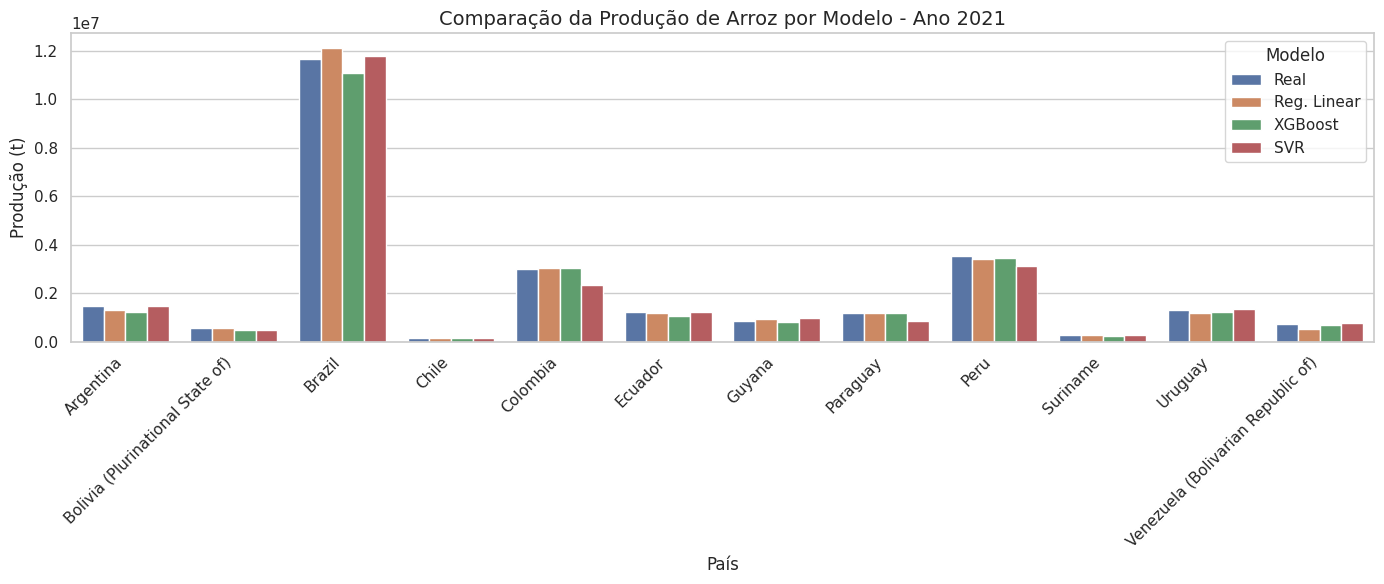

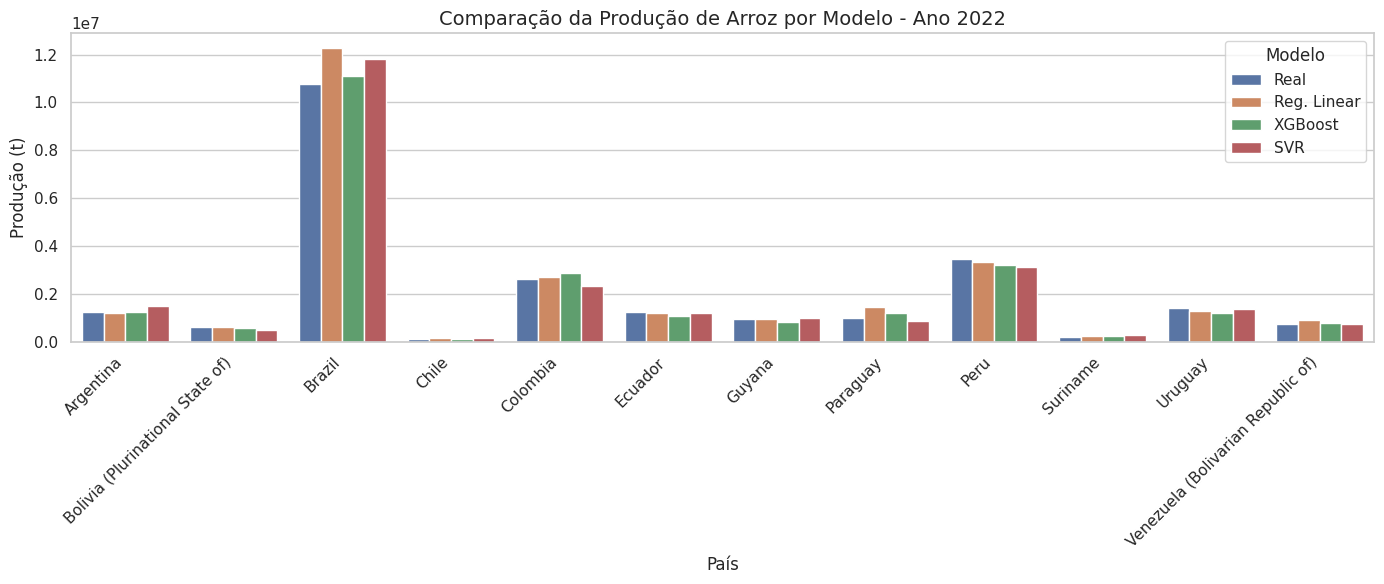

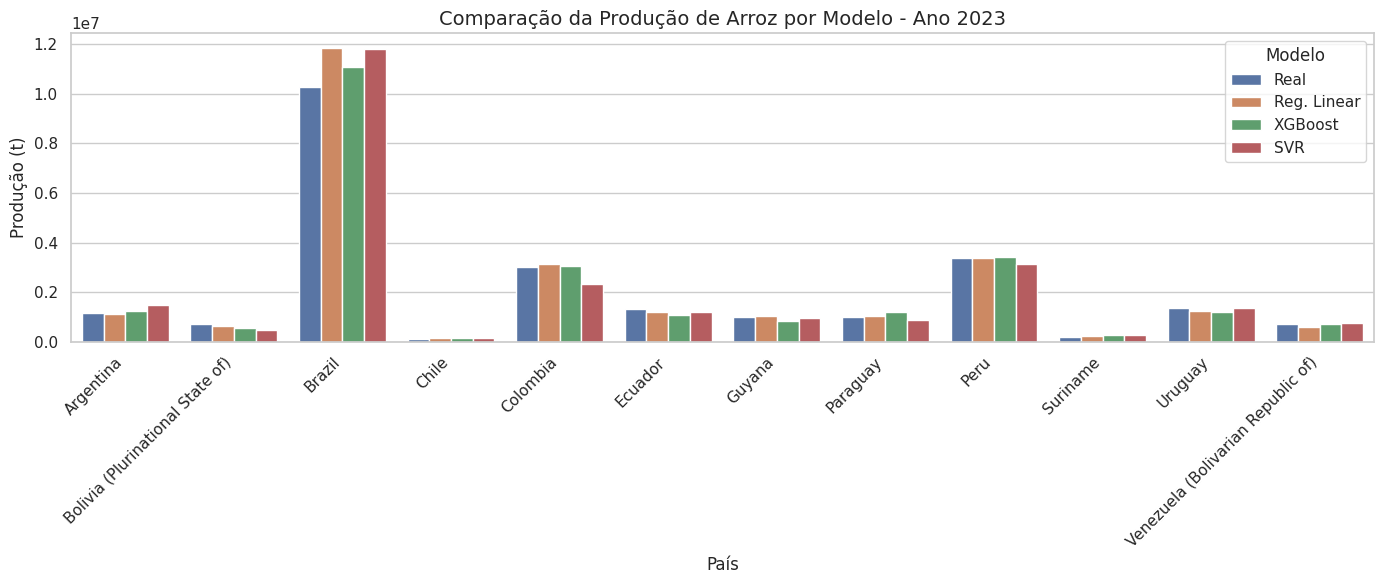

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Garantir estilo bonito
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Loop para um gráfico por ano
anos_previstos = sorted(df_resultado['Ano_Previsto'].unique())

for ano in anos_previstos:
    df_ano = df_resultado[df_resultado['Ano_Previsto'] == ano].copy()

    # Reformata para gráfico de barras agrupadas
    df_plot = pd.melt(df_ano,
                      id_vars='Area',
                      value_vars=['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR'],
                      var_name='Modelo',
                      value_name='Produção')

    # Renomear para legenda mais limpa
    df_plot['Modelo'] = df_plot['Modelo'].replace({
        'Production_Real': 'Real',
        'Prod_LR': 'Reg. Linear',
        'Prod_XGB': 'XGBoost',
        'Prod_SVR': 'SVR'
    })

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_plot, x='Area', y='Produção', hue='Modelo')
    plt.title(f'Comparação da Produção de Arroz por Modelo - Ano {ano}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Produção (t)')
    plt.xlabel('País')
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

In [ ]:
media_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR']
].mean().reset_index()


media_erro_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

print("Média da produção e previsões por ano:")
print(media_por_ano)

print("\nMédia dos erros percentuais por ano:")
print(media_erro_por_ano)

Média da produção e previsões por ano:
   Ano_Previsto  Production_Real      Prod_LR     Prod_XGB     Prod_SVR
0          2021     2,155,520.93 2,150,709.70 2,054,607.62 2,066,239.90
1          2022     2,018,670.75 2,181,941.72 2,030,666.00 2,066,222.97
2          2023     2,017,919.87 2,127,948.25 2,059,435.38 2,066,218.04

Média dos erros percentuais por ano:
   Ano_Previsto  Erro_%_Prod_LR  Erro_%_Prod_XGB  Erro_%_Prod_SVR
0          2021            6.59             6.12             8.94
1          2022           15.36            13.06            16.70
2          2023            9.86            12.22            17.37


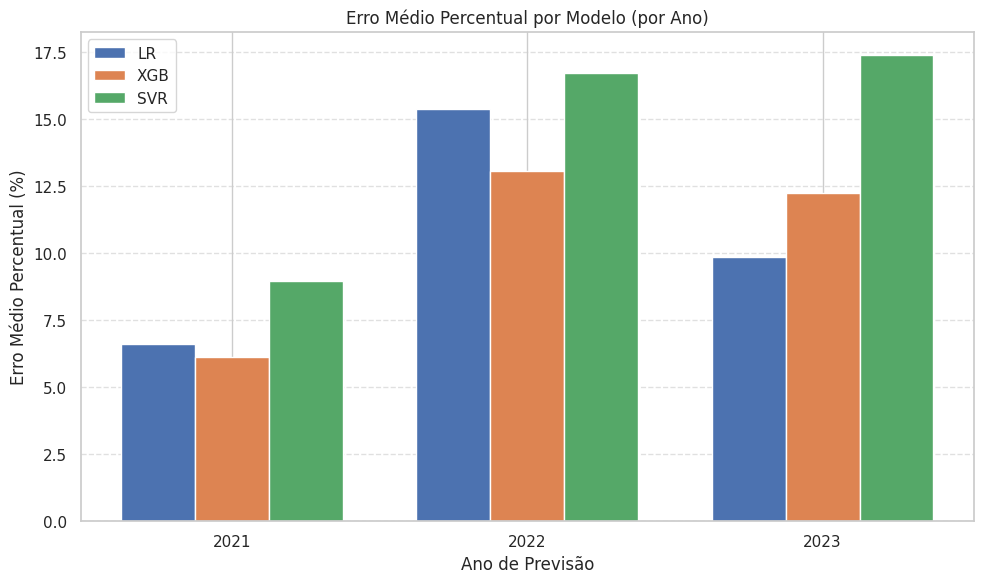

In [ ]:
import matplotlib.pyplot as plt

# Supondo que você já tenha o DataFrame `media_erro_por_ano`
plt.figure(figsize=(10, 6))

# Plotando as barras lado a lado por modelo
largura = 0.25
anos = media_erro_por_ano['Ano_Previsto']
x = range(len(anos))

plt.bar([p - largura for p in x], media_erro_por_ano['Erro_%_Prod_LR'], width=largura, label='LR')
plt.bar(x, media_erro_por_ano['Erro_%_Prod_XGB'], width=largura, label='XGB')
plt.bar([p + largura for p in x], media_erro_por_ano['Erro_%_Prod_SVR'], width=largura, label='SVR')

# Eixos e rótulos
plt.xticks(x, anos)
plt.ylabel('Erro Médio Percentual (%)')
plt.xlabel('Ano de Previsão')
plt.title('Erro Médio Percentual por Modelo (por Ano)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index().sort_values(by='Area')

# Exibir o resultado
print("Média dos erros percentuais por país:")
print(media_erro_por_pais.round(2))

Média dos erros percentuais por país:
                                  Area  Erro_%_Prod_LR  Erro_%_Prod_XGB  \
0                            Argentina            4.64             6.80   
1     Bolivia (Plurinational State of)            4.24            13.14   
2                               Brazil           11.01             5.21   
3                                Chile           25.15            16.46   
4                             Colombia            2.91             4.15   
5                              Ecuador            5.97            14.62   
6                               Guyana            4.64            10.98   
7                             Paraguay           17.51            14.59   
8                                 Peru            2.49             3.94   
9                             Suriname           16.65            21.29   
10                             Uruguay           10.71            11.03   
11  Venezuela (Bolivarian Republic of)           21.34        

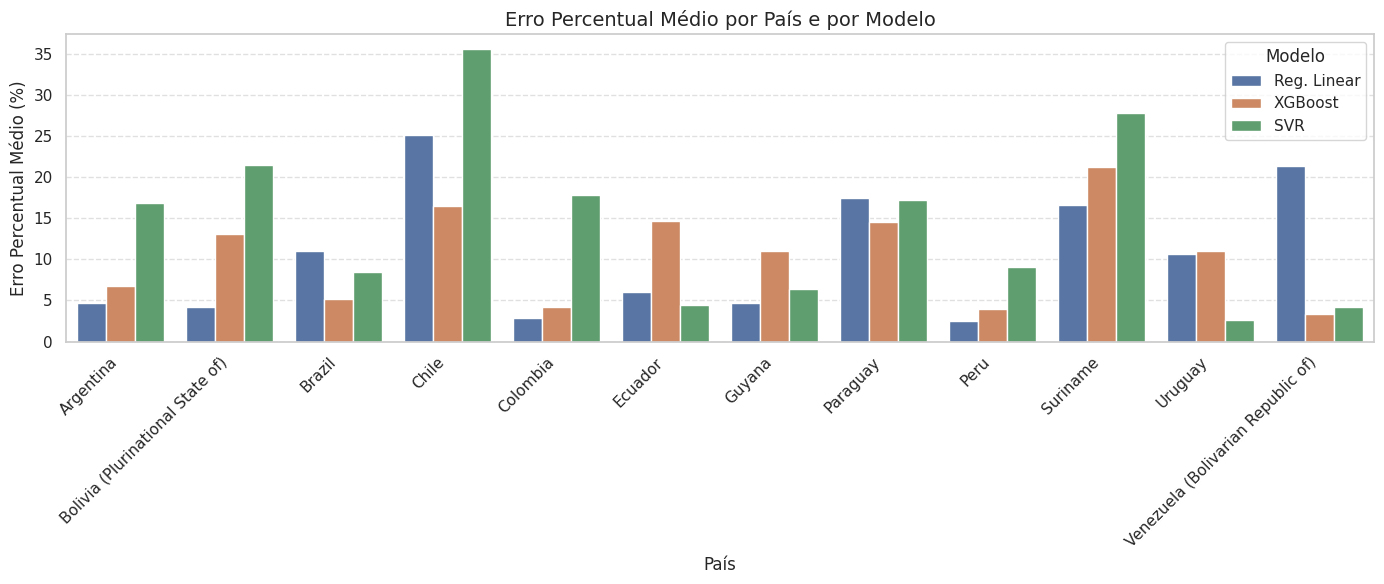

In [ ]:
# Calcular média dos erros percentuais por país
media_erro_por_pais = df_resultado.groupby('Area')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

# Visualização com seaborn e matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Reformata para gráfico de barras agrupadas
df_plot_pais = pd.melt(media_erro_por_pais,
                       id_vars='Area',
                       value_vars=['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR'],
                       var_name='Modelo',
                       value_name='Erro Percentual Médio')

# Renomear para legenda mais limpa
df_plot_pais['Modelo'] = df_plot_pais['Modelo'].replace({
    'Erro_%_Prod_LR': 'Reg. Linear',
    'Erro_%_Prod_XGB': 'XGBoost',
    'Erro_%_Prod_SVR': 'SVR'
})

# Gráfico
plt.figure(figsize=(14, 6))
sns.barplot(data=df_plot_pais, x='Area', y='Erro Percentual Médio', hue='Modelo')
plt.title('Erro Percentual Médio por País e por Modelo', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Erro Percentual Médio (%)')
plt.xlabel('País')
plt.legend(title='Modelo')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

                   MAPE Médio (%)  Desvio Padrão (%)
Linear Regression           32.38               3.15
XGBoost                     13.72               4.35
SVR                        121.15              11.64


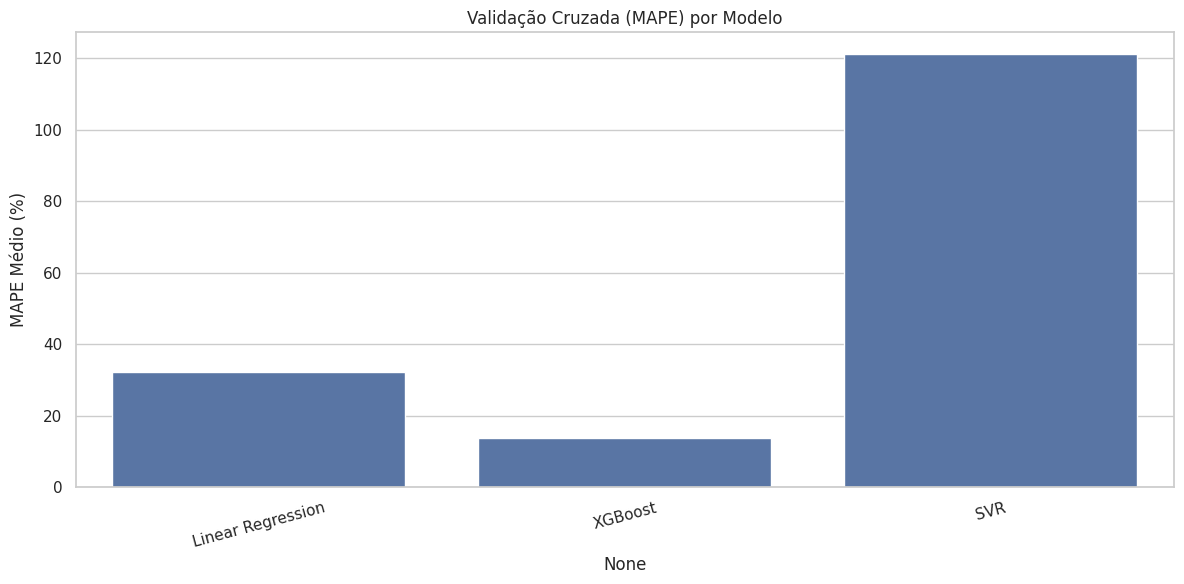

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import pandas as pd

# Supondo que X e y já estejam definidos:
# X = df_treino[atributos]
# y = df_treino["Production"]

# Definindo as variáveis de entrada e saída
atributos = ['Area harvested (ha)', 'Yield (kg/ha)']  # ou os que fizerem sentido
X = df_treino[atributos]
y = df_treino['Production (t)']

# Normalização para SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Métrica MAPE customizada para usar no cross_val_score
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Dicionário de modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.2)
}

# Avaliação com cross-validation
resultados_cv = {}
for nome, modelo in modelos.items():
    if nome == "SVR":
        scores = cross_val_score(modelo, X_scaled, y, cv=5, scoring=mape_scorer)
    else:
        scores = cross_val_score(modelo, X, y, cv=5, scoring=mape_scorer)
    resultados_cv[nome] = {
        "MAPE Médio (%)": -scores.mean() * 100,
        "Desvio Padrão (%)": scores.std() * 100
    }

# Criar tabela
df_cv = pd.DataFrame(resultados_cv).T
df_cv = df_cv.round(2)

# Exibir
import matplotlib.pyplot as plt
import seaborn as sns

print(df_cv)

# Opcional: gráfico de barras
sns.barplot(x=df_cv.index, y="MAPE Médio (%)", data=df_cv)
plt.ylabel("MAPE Médio (%)")
plt.title("Validação Cruzada (MAPE) por Modelo")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()